In [1]:
import pandas as pd
import re
import unicodedata
import nltk
import prepare
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Spam data

1. Load the spam data set.
2. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?
3. Is there any overlap in the bigrams for the spam data and the ham data?
4. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [2]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

df = pd.read_csv('./spam_clean.csv')
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [4]:
#The words that appear in legitimate text messages
ham_words = clean(' '.join(df[df.label == 'ham'].text))

#The words that appear in spam text messages
spam_words = clean(' '.join(df[df.label == 'spam'].text))

#All of the words
all_words = clean(' '.join(df.text))

In [5]:
#turn into series
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [6]:
#create one dataframe
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


In [7]:
#most frequently occurring words
word_counts.sort_values(by='all', ascending=False).head(10)

,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
4,287,168,119
dont,279,257,22
ok,277,272,5
free,275,59,216
know,267,241,26


In [8]:
#uniquely spam or ham
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(6),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(6)])

,all,ham,spam
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0
awarded,38,0,38
18,43,0,43
guaranteed,50,0,50
tone,73,0,73


Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

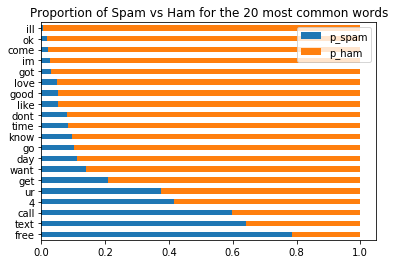

In [9]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')

In [10]:
(word_counts
 [(word_counts.spam > 10) & (word_counts.ham > 10)]
 .assign(ratio=lambda df: df.spam / (df.ham + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))

,all,ham,spam,ratio
im,462,449,13,0.028953
good,235,223,12,0.053809
like,245,232,13,0.056032
need,182,171,11,0.064324
dont,279,257,22,0.085600
contact,70,14,56,3.997145
win,76,15,61,4.063957
cash,74,12,62,5.162365
mobile,150,15,135,8.994004
txt,163,13,150,11.529593


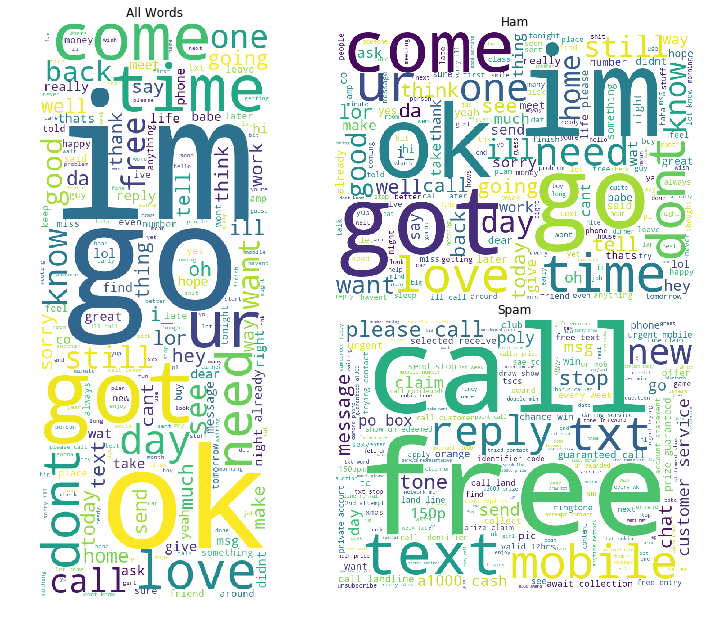

In [11]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')

### Bigrams

In [12]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()

(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

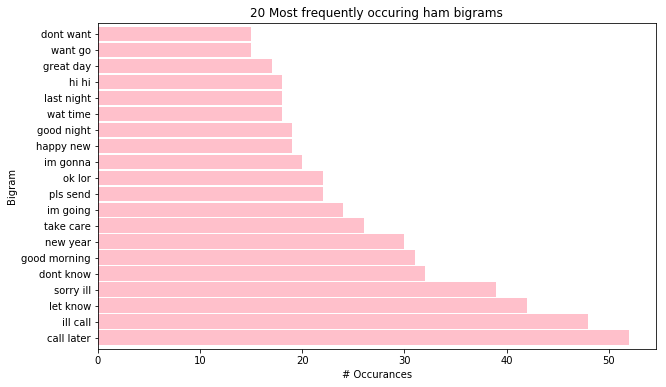

In [13]:
top_20_ham_bigrams.plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

(-0.5, 799.5, 399.5, -0.5)

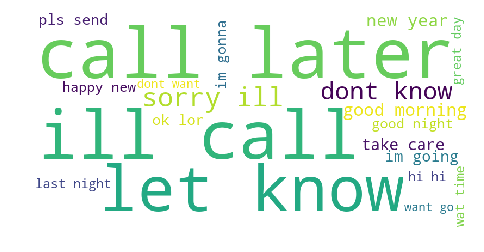

In [14]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

### Trigrams

In [15]:
top_20_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                      .value_counts()
                      .head(20))

top_20_ham_trigrams.head()

(ill, call, later)      42
(sorry, ill, call)      38
(happy, new, year)      19
(pls, send, message)    13
(pick, phone, right)    12
dtype: int64

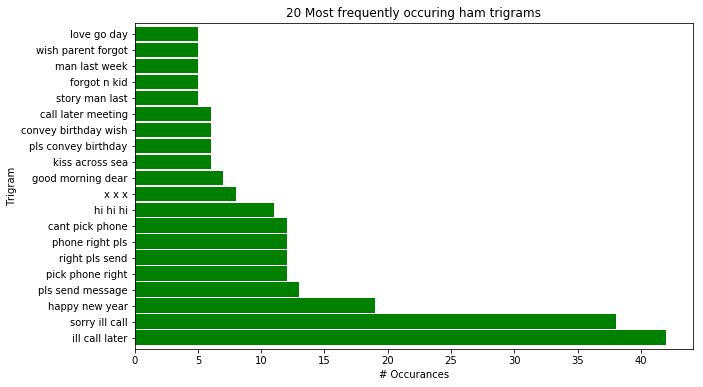

In [16]:
top_20_ham_trigrams.plot.barh(color='green', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

In [17]:
top_20_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts()
                      .head(20))

top_20_spam_trigrams.head()

(prize, guaranteed, call)     21
(call, customer, service)     15
(reply, call, 08000930705)    14
(land, line, claim)           14
(private, 2003, account)      13
dtype: int64

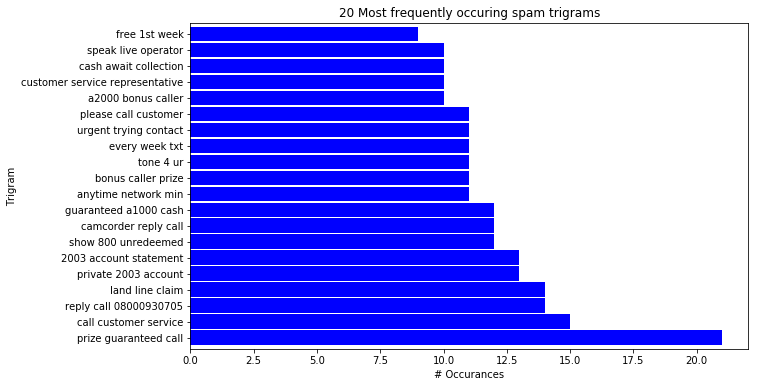

In [18]:
top_20_spam_trigrams.plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring spam trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

(-0.5, 799.5, 399.5, -0.5)

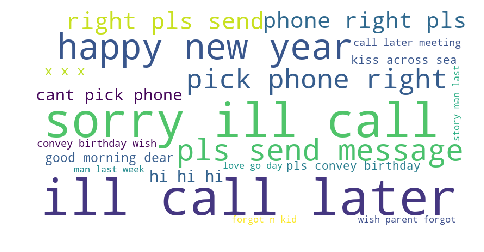

In [19]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_ham_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

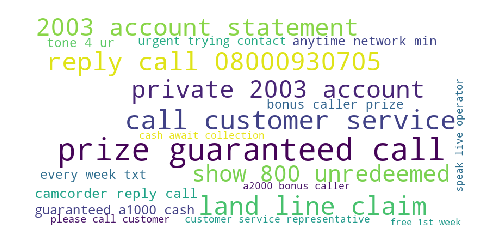

In [20]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_spam_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

# Blog data

In [21]:
import acquire
import prepare

In [22]:
blogs = acquire.blog_articles()

/Users/kathrynsalts/Codeup/methodologies/nlp/acquire_codeup_blog.py:9: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 9 of the file /Users/kathrynsalts/Codeup/methodologies/nlp/acquire_codeup_blog.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(response.text)
/Users/kathrynsalts/Codeup/methodologies/nlp/acquire_codeup_blog.py:17: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The cod

In [23]:
# blogs

In [24]:
clean_blogs = prepare.prepare_article_data(blogs)

In [25]:
df = pd.DataFrame.from_dict(clean_blogs)
df

,clean,content,lemmatized,original,stemmed,title
0,rumors true time arrived codeup officially ope...,\nThe rumors are true! The time has arrived. C...,\n the rumor be true the time have arrive code...,\nThe rumors are true! The time has arrived. C...,the rumor are true the time ha arriv codeup ha...,Codeup Data Science Career Accelerator Is Here
1,dimitri antoniou maggie giust data science big...,\nBy Dimitri Antoniou and Maggie Giust\nData S...,\n by dimitri antoniou and maggie giust \n dat...,\nBy Dimitri Antoniou and Maggie Giust\nData S...,by dimitri antoni and maggi giust data scienc ...,Codeup Ada Data Science
2,dimitri antoniou week ago codeup launched imme...,"\nBy Dimitri Antoniou\nA week ago, Codeup laun...",\n by dimitri antoniou \n a week ago codeup la...,"\nBy Dimitri Antoniou\nA week ago, Codeup laun...",by dimitri antoni a week ago codeup launch our...,Data Science vs Data Analytics. What's the dif...
3,10 tips crush sa tech job fair sa tech job fai...,\n10 Tips to Crush It at the SA Tech Job Fair\...,\n 10 tip to crush at the sa tech job fair \n ...,\n10 Tips to Crush It at the SA Tech Job Fair\...,10 tip to crush it at the sa tech job fair sa ...,10 Tips to Crush It at The SA Tech Job Fair
4,competitor bootcamps closing model danger prog...,\nCompetitor Bootcamps Are Closing. Is the Mod...,\n competitor bootcamp be close be the model i...,\nCompetitor Bootcamps Are Closing. Is the Mod...,competitor bootcamp are close is the model in ...,Competitor Bootcamps are closing. Is the model...


In [26]:
blog = (' '.join(df.clean))
blog

'rumors true time arrived codeup officially opened applications new data science career accelerator 25 seats available immersive program one kind san antonio help land job glassdoors 1 best job america data science method providing actionable intelligence data data revolution hit san antonio resulting explosion data scientist positions across companies like usaa accenture booz allen hamilton heb weve even seen utsa invest 70 cybersecurity center school data science built program specifically meet growing demands industry program 18 weeks long fulltime handson projectbased curriculum development instruction led senior data scientist maggie giust worked heb capital group rackspace along input dozens practitioners hiring partners students work real data sets realistic problems entire data science pipeline collection deployment receive professional development training resume writing interviewing continuing education prepare smooth transition workforce focus applied data science immediate 

In [28]:
pd.Series(blog.split()).value_counts()

data              77
science           28
learning          20
machine           14
job               14
like              12
model             11
company           11
one                9
new                9
education          9
companies          8
fair               8
tech               8
work               8
scientist          8
statistics         8
look               7
us                 7
dont               7
big                7
make               7
time               7
business           6
questions          6
intelligence       6
first              6
giphy              6
skills             6
bootcamp           6
                  ..
left               1
remember           1
depending          1
code               1
higher             1
techniques         1
fundamentals       1
tried              1
nice               1
line               1
sound              1
whether            1
quick              1
educations         1
complex            1
immediate          1
detection    

In [29]:
blog_words = list(pd.Series(blog.split()))

In [30]:
top_20_blog_bigrams = (pd.Series(nltk.ngrams(blog_words, 2))
                      .value_counts()
                      .head(20))

top_20_blog_bigrams.head()

(data, science)        28
(machine, learning)    14
(job, fair)             8
(data, scientist)       8
(via, giphy)            6
dtype: int64

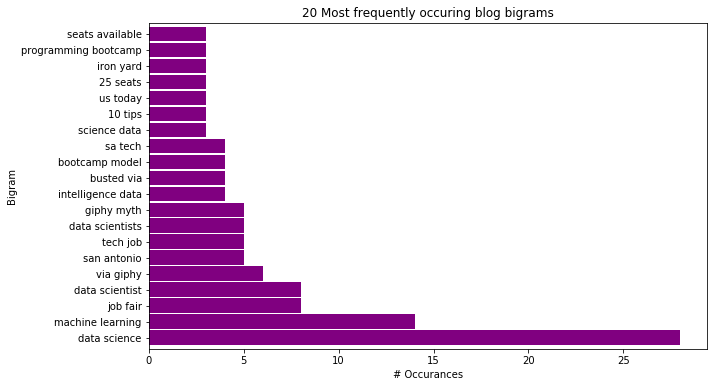

In [31]:
top_20_blog_bigrams.plot.barh(color='purple', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring blog bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_blog_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

(-0.5, 799.5, 399.5, -0.5)

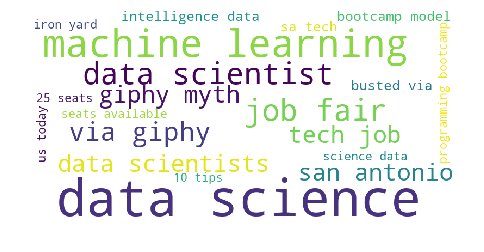

In [32]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_blog_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

# News articles

In [33]:
news = acquire.news_articles()

/Users/kathrynsalts/Codeup/methodologies/nlp/acquire_news_articles.py:20: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 20 of the file /Users/kathrynsalts/Codeup/methodologies/nlp/acquire_news_articles.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(response.text)
/Users/kathrynsalts/Codeup/methodologies/nlp/acquire_news_articles.py:20: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.


In [34]:
business = news[0]

In [35]:
clean_business = prepare.prepare_article_data(business)

In [36]:
# clean_news

In [37]:
df = pd.DataFrame.from_dict(clean_business)
df

,category,clean,content,lemmatized,original,stemmed,title
0,business,london court wednesday denied bail nirav modi ...,A London court on Wednesday denied bail to Nir...,a london court on wednesday deny bail to nirav...,A London court on Wednesday denied bail to Nir...,a london court on wednesday deni bail to nirav...,Nirav Modi denied bail for third time despite ...
1,business,indian technician working kuwait airways crush...,An Indian technician working with Kuwait Airwa...,an indian technician work with kuwait airway b...,An Indian technician working with Kuwait Airwa...,an indian technician work with kuwait airway w...,Indian technician towing Kuwait Airways plane ...
2,business,us president donald trump ' businesses mainly ...,"US President Donald Trump's businesses, mainly...",president donald trump business mainly casino...,"US President Donald Trump's businesses, mainly...",us presid donald trump' busi mainli casino hot...,"Trump lost $1 bn over a decade, avoided paying..."
3,business,tata steel europe said demand fall uschina tra...,Tata Steel Europe has said demand will fall if...,tata steel europe have say demand will fall if...,Tata Steel Europe has said demand will fall if...,tata steel europ ha said demand will fall if t...,"Tata Steel says US, China have two days left t..."
4,business,following reports rooh afza shortage ramzan in...,Following reports of Rooh Afza shortage during...,follow report of rooh afza shortage during ram...,Following reports of Rooh Afza shortage during...,follow report of rooh afza shortag dure ramzan...,Hamdard Pakistan offers to help after Rooh Afz...
5,business,bankrupt essar steel ' promoters ruias alleged...,"Bankrupt Essar Steel's promoters, the Ruias, a...",bankrupt essar steel promoter the ruia allege ...,"Bankrupt Essar Steel's promoters, the Ruias, a...",bankrupt essar steel' promot the ruia alleg th...,Lakshmi Mittal hid links with brothers' defaul...
6,business,british entrepreneur jason unsworth claimed su...,After British entrepreneur Jason Unsworth clai...,after british entrepreneur jason unsworth clai...,After British entrepreneur Jason Unsworth clai...,after british entrepreneur jason unsworth clai...,Father not bidding for Jet: Goyal's daughter a...
7,business,apple reportedly zeroed several upscale locati...,Apple has reportedly zeroed in on several upsc...,apple have reportedly zero in on several upsca...,Apple has reportedly zeroed in on several upsc...,appl ha reportedli zero in on sever upscal loc...,Apple may open its 1st India retail store in M...
8,business,cryptocurrency exchange binance revealed hacke...,Cryptocurrency exchange Binance has revealed h...,cryptocurrency exchange binance have reveal ha...,Cryptocurrency exchange Binance has revealed h...,cryptocurr exchang binanc ha reveal hacker sto...,$40M worth bitcoins stolen from 4th largest cr...
9,business,billionaire elon musk responding twitter user ...,"Billionaire Elon Musk, responding to a Twitter...",billionaire elon musk respond to a twitt user ...,"Billionaire Elon Musk, responding to a Twitter...",billionair elon musk respond to a twitter user...,No choice or Tesla would die: CEO Musk on work...


In [38]:
news_business = (' '.join(df.clean))
news_business

"london court wednesday denied bail nirav modi third time despite offering 18 crore security nirav ' lawyer said client granted bail funds frozen shown ' no longer seeking residence abroad 48yearold facing extradition india 14000crore pnb scam indian technician working kuwait airways crushed death kuwait city airport monday wheels aircraft accident occurred empty kuwait airways boeing 777 towed anand ramachandran tow bar reportedly broke killing spot ramachandran ' body sent home state kerala us president donald trump ' businesses mainly casinos hotels apartment buildings lost 117 billion 1985 1994 according new york times trump lost much money able avoid paying income taxes eight 10 years newspaper added trump reportedly posted losses 250 million 1990 1991 tata steel europe said demand fall uschina trade war doesnt get sorted day tomorrow us president donald trump said tariffs 200 billion chinese goods would increase friday 25 10 us china hold critical round trade talks washington thu

In [39]:
pd.Series(news_business.split()).value_counts()

'                  29
said               18
us                 11
india               7
airways             7
data                7
earlier             6
crore               6
million             6
added               6
wednesday           5
jet                 5
may                 5
billion             5
group               5
reportedly          5
china               5
trump               5
stake               5
court               4
led                 4
nearly              4
bid                 4
last                4
week                4
airline             4
bail                4
days                3
president           3
posted              3
                   ..
protection          1
reveal              1
still               1
fall                1
48yearold           1
cofounder           1
jail                1
245                 1
wall                1
following           1
entering            1
bar                 1
query               1
weeks               1
client    

In [40]:
business_words = list(pd.Series(news_business.split()))

In [41]:
top_20_business_bigrams = (pd.Series(nltk.ngrams(business_words, 2))
                      .value_counts()
                      .head(20))

top_20_business_bigrams.head()

(jet, airways)        5
(stake, company)      3
(us, president)       3
(donald, trump)       3
(arcelormittal, ')    3
dtype: int64

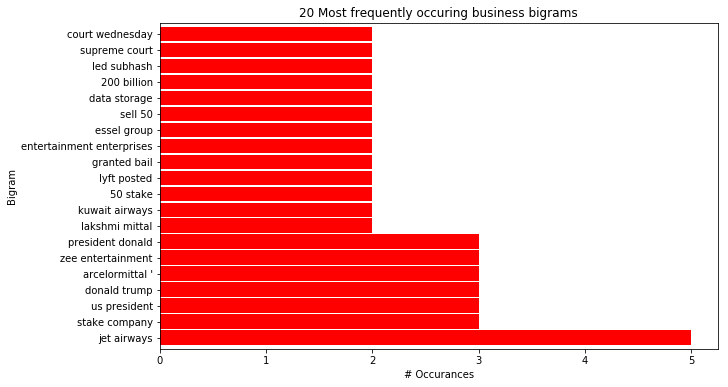

In [42]:
top_20_business_bigrams.plot.barh(color='red', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring business bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_business_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

(-0.5, 799.5, 399.5, -0.5)

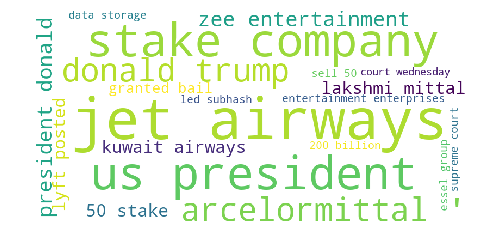

In [43]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_business_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

In [50]:
tech = news[2]

In [51]:
clean_tech = prepare.prepare_article_data(tech)

In [52]:
df = pd.DataFrame.from_dict(clean_tech)
df

,category,clean,content,lemmatized,original,stemmed,title
0,technology,oneplus announced oneplus 66t users eligible d...,OnePlus has announced that OnePlus 6/6T users ...,oneplus have announce that oneplus 66 t user b...,OnePlus has announced that OnePlus 6/6T users ...,oneplu ha announc that oneplu 66t user are eli...,OnePlus 7 Pro set to launch with Android Q beta
1,technology,several people locating east delhi ' ghazipur ...,Several people are locating East Delhi's Ghazi...,several people be locate east delhi ghazipur m...,Several people are locating East Delhi's Ghazi...,sever peopl are locat east delhi' ghazipur' 'm...,People give 5-stars to Delhi 'Mountain of Garb...
2,technology,addressing google io 2019 keynote california t...,Addressing Google I/O 2019 keynote in Californ...,address google io 2019 keynote in california o...,Addressing Google I/O 2019 keynote in Californ...,address googl io 2019 keynot in california on ...,Ending conference in 2 hrs over Barca vs Liver...
3,technology,google ceo sundar pichai tuesday announced chr...,Google CEO Sundar Pichai on Tuesday announced ...,google ceo sundar pichai on tuesday announce c...,Google CEO Sundar Pichai on Tuesday announced ...,googl ceo sundar pichai on tuesday announc it ...,Google to add Incognito mode to Search and Map...
4,technology,google ceo sundar pichai new york times articl...,"Google CEO Sundar Pichai, in a New York Times ...",google ceo sundar pichai in a new york time ar...,"Google CEO Sundar Pichai, in a New York Times ...",googl ceo sundar pichai in a new york time art...,"Privacy can't be a luxury, must be available t..."
5,technology,mumbaibased wadhwani institute ai among 20 org...,Mumbai-based Wadhwani Institute for AI is amon...,mumbaibased wadhwani institute for ai be among...,Mumbai-based Wadhwani Institute for AI is amon...,mumbaibas wadhwani institut for ai is among 20...,Mumbai's Wadhwani AI to receive $2 million Goo...
6,technology,manav rachna institute research studies farida...,Manav Rachna Institute of Research and Studies...,manav rachna institute of research and study f...,Manav Rachna Institute of Research and Studies...,manav rachna institut of research and studi fa...,Indian students' team comes 2nd at Microsoft c...
7,technology,international researchers made smart suitcase ...,International researchers have made a smart su...,international researcher have make a smart sui...,International researchers have made a smart su...,intern research have made a smart suitcas that...,Smart suitcase that warns blind users before c...
8,technology,google 2019 io developers conference announced...,"Google, in its 2019 I/O developers conference,...",google in 2019 io developer conference announc...,"Google, in its 2019 I/O developers conference,...",googl in it 2019 io develop confer announc it ...,Google Assistant drops need to say 'Hey Google...
9,technology,cryptocurrency exchange binance revealed hacke...,Cryptocurrency exchange Binance has revealed h...,cryptocurrency exchange binance have reveal ha...,Cryptocurrency exchange Binance has revealed h...,cryptocurr exchang binanc ha reveal hacker sto...,$40M worth bitcoins stolen from 4th largest cr...


In [53]:
news_tech = (' '.join(df.clean))
news_tech

"oneplus announced oneplus 66t users eligible download latest android q beta release starting today available oneplus 7 pro may 14 notably android q beta allow users experience latest technologies including new gesturebased navigation dark theme privacy enhancements contribute burdenless experience several people locating east delhi ' ghazipur ' ' mountain garbage ' google maps leaving 5star reviews bringing average rating 41 stars 2018 landfill stood height 65 metres eight metres less qutub minar place beautiful aroma find one sarcastic reviews read addressing google io 2019 keynote california tuesday google ceo sundar pichai said ' going keep keynote two hours ' especially barcelona kicks liverpool noonit amazing game added special augmented reality search results updated google assistant onetap access privacy settings unveiled keynote google ceo sundar pichai tuesday announced chrome browserfamed incognito mode would expanded maps search year however incognito mode maps would not di

In [54]:
pd.Series(news_tech.split()).value_counts()

'                 37
google            15
said              10
users              8
new                6
added              6
apple              6
ceo                5
support            5
microsoft          5
2019               5
facebook           5
announced          5
also               5
instagram          5
adding             5
blockchain         5
first              5
cryptocurrency     4
assistant          4
privacy            4
pichai             4
world              4
us                 4
platform           4
per                4
people             4
million            4
game               4
posts              4
                  ..
week               1
finance            1
norms              1
customers          1
jingying           1
rubber             1
audio              1
minar              1
titled             1
apologised         1
place              1
wrote              1
developer          1
reviewer           1
analysed           1
googleorg          1
burdenless   

In [55]:
tech_words = list(pd.Series(news_tech.split()))

In [56]:
top_20_tech_bigrams = (pd.Series(nltk.ngrams(tech_words, 2))
                      .value_counts()
                      .head(20))

top_20_tech_bigrams.head()

(ceo, sundar)            3
(warren, buffett)        3
(sundar, pichai)         3
(google, ceo)            3
(berkshire, hathaway)    2
dtype: int64

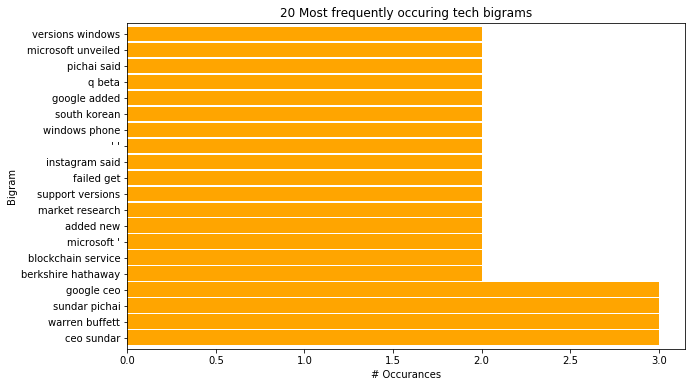

In [58]:
top_20_tech_bigrams.plot.barh(color='orange', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring tech bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_tech_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

(-0.5, 799.5, 399.5, -0.5)

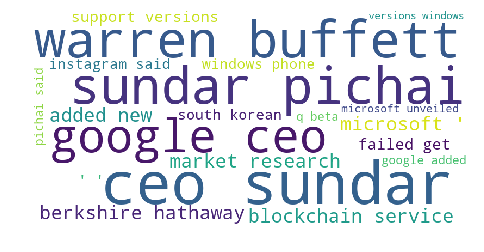

In [60]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_tech_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')